In [3]:
import pymc3 as pm
import arviz as az
import pandas as pd
import numpy as np
from theano import shared
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [4]:
def standardize(x):
    return (x - np.mean(x)) / np.std(x)

In [5]:
milk = pd.read_csv("https://raw.githubusercontent.com/schubertjan/resources/master/Rethinking_2/Data/milk.csv", sep = ";")

In [6]:
milk["K"] = standardize(milk["kcal.per.g"])
milk["N"] = standardize(milk["neocortex.perc"])
milk["M"] = standardize(np.log(milk["mass"]))

In [7]:
milk.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,K,N,M
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-0.956680,-2.144217,-0.463904
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,-0.830572,NaN,-0.422348
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,-1.145842,NaN,-0.312595
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,-1.019734,NaN,-0.575027
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,-0.263087,NaN,-0.394336


In [8]:
milk = milk.dropna(axis=0)
milk.shape

(17, 11)

In [9]:
shared_N = shared(milk["N"].values)

m_5_5_draft = pm.Model()

with m_5_5_draft:
    bN = pm.Normal("bN", 0, 1)
    a = pm.Normal("a", 0, 1)
    mu = pm.Deterministic("mu", a + bN * shared_N)
    sigma = pm.Exponential("sigma", 1)
    K = pm.Normal("K", mu, sigma, observed=milk["K"])

In [10]:
xseq = [-2,2] # jenom -2, 2 abychom meli dva body, ktere muzeme spojit
shared_N.set_value(xseq)

with m_5_5_draft:
    m_5_5_draft_prior_predictive = pm.sample_prior_predictive()

[]

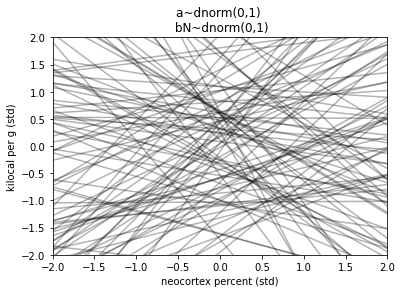

In [11]:
fig, ax = plt.subplots()

for i in range(100):
    ax.plot(xseq, m_5_5_draft_prior_predictive["mu"][i], alpha = 0.3, color = "black")
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_title("a~dnorm(0,1) \n bN~dnorm(0,1)")
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)")
plt.plot()

To je ocividne spatny prior. Spousta vysledku je mimo pozorovane hodnoty

In [12]:
shared_N = shared(milk["N"].values)

m_5_5 = pm.Model()

with m_5_5:
    bN = pm.Normal("bN", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bN * shared_N)
    sigma = pm.Exponential("sigma", 1)
    K = pm.Normal("K", mu, sigma, observed=milk["K"])

In [13]:
xseq = np.array([-2,2])
shared_N.set_value(xseq)

with m_5_5:
    m_5_5_prior_predictive = pm.sample_prior_predictive()

[]

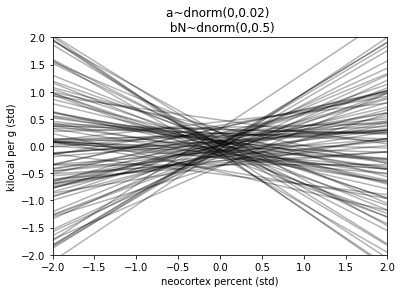

In [14]:
fig, ax = plt.subplots()

for i in range(100):
    ax.plot(xseq, m_5_5_prior_predictive["mu"][i], alpha = 0.3, color = "black")
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_title("a~dnorm(0,0.02) \n bN~dnorm(0,0.5)")
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)")
plt.plot()

This looks much better

In [15]:
shared_N.set_value(milk["N"])

with m_5_5:
    m_5_5_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a, bN]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [16]:
az.summary(m_5_5_trace, var_names=["a", "bN", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.038,0.166,-0.246,0.365,0.002,0.003,4622.0,1870.0,4601.0,2812.0,1.0
bN,0.131,0.246,-0.311,0.608,0.004,0.003,4012.0,2639.0,4014.0,2775.0,1.0
sigma,1.127,0.206,0.778,1.494,0.003,0.002,4223.0,3900.0,4433.0,2645.0,1.0


In [17]:
shared_M = shared(milk["M"].values)

m_5_6 = pm.Model()

with m_5_6:
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bM * shared_M)
    sigma = pm.Exponential("sigma", 1)
    K = pm.Normal("K", mu, sigma, observed=milk["K"])
    m_5_6_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a, bM]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [18]:
az.summary(m_5_6_trace, var_names = ["a", "bM", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.042,0.160,-0.248,0.354,0.002,0.003,4542.0,2013.0,4556.0,2971.0,1.0
bM,-0.272,0.211,-0.634,0.169,0.003,0.003,4413.0,3352.0,4439.0,2560.0,1.0
sigma,1.071,0.201,0.740,1.434,0.003,0.002,3818.0,3573.0,4077.0,2513.0,1.0


In [19]:
m_5_7 = pm.Model()

with m_5_7:
    a = pm.Normal("a", 0, 0.2)
    bN = pm.Normal("bN", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    mu =pm.Deterministic("mu", a + bN * shared_N + bM * shared_M)
    sigma = pm.Exponential("sigma", 1)
    K = pm.Normal("K", mu, sigma, observed = milk["K"])
    m_5_7_trace = pm.sample(tune = 2000, draws = 10000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, bN, a]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 16 seconds.


In [20]:
# contrafactuals for both models
n = 30
## holding M = 0
shared_M.set_value(np.zeros(n))
xseq = np.linspace(-2, 2, num = n)
shared_N.set_value(xseq)
with m_5_7:
    m_5_7_contrafactual_m_zero = pm.sample_posterior_predictive(m_5_7_trace, var_names=["mu"])


## holding N = 0
shared_N.set_value(np.zeros(n))
xseq = np.linspace(-2, 2, num = n)
shared_M.set_value(xseq)
with m_5_7:
    m_5_7_contrafactual_n_zero = pm.sample_posterior_predictive(m_5_7_trace, var_names=["mu"])



[]

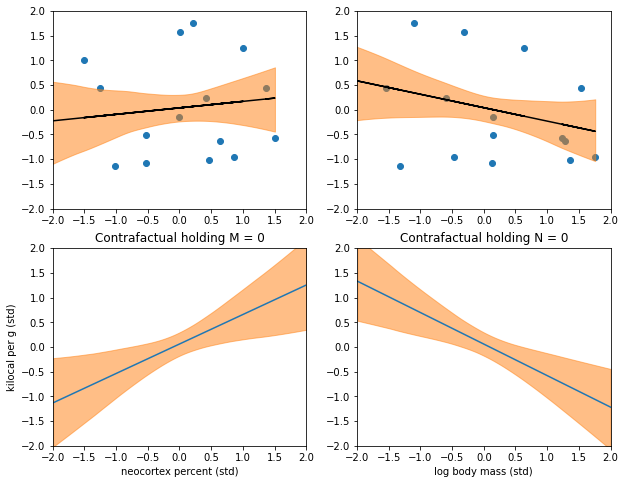

In [21]:
fig, ax = plt.subplots(2,2, figsize=(10,8))

ax[0,0].scatter(milk["N"], milk["K"])
ax[0,0].plot(milk["N"], m_5_5_trace["mu"].mean(axis=0), color = "black")
az.plot_hpd(milk["N"], m_5_5_trace["mu"], ax = ax[0,0], credible_interval = 0.89)
ax[0,1].scatter(milk["M"], milk["K"])
ax[0,1].plot(milk["M"], m_5_6_trace["mu"].mean(axis=0), color = "black")
az.plot_hpd(milk["M"], m_5_6_trace["mu"], ax = ax[0,1], credible_interval = 0.89)


ax[1,0].plot(xseq, m_5_7_contrafactual_m_zero["mu"].mean(axis=0))
az.plot_hpd(xseq, m_5_7_contrafactual_m_zero["mu"], credible_interval=0.89, ax=ax[1,0])
ax[1,0].set_title("Contrafactual holding M = 0")
ax[1,0].set_xlabel("neocortex percent (std)")
ax[1,0].set_ylabel("kilocal per g (std)")

ax[1,1].plot(xseq, m_5_7_contrafactual_n_zero["mu"].mean(axis=0))
az.plot_hpd(xseq, m_5_7_contrafactual_n_zero["mu"], credible_interval=0.89, ax=ax[1,1])
ax[1,1].set_title("Contrafactual holding N = 0")
ax[1,1].set_xlabel("log body mass (std)")
ax[1,1].set_ylabel("")

ax[0,0].set_xlim(-2,2)
ax[0,1].set_xlim(-2,2)
ax[1,0].set_xlim(-2,2)
ax[1,1].set_xlim(-2,2)
ax[0,0].set_ylim(-2,2)
ax[0,1].set_ylim(-2,2)
ax[1,0].set_ylim(-2,2)
ax[1,1].set_ylim(-2,2)

plt.plot()

In [22]:
shared_N.set_value(milk["N"])
shared_M.set_value(milk["M"])

az.summary(m_5_7_trace, var_names = ["a", "bN", "bM", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.059,0.146,-0.216,0.334,0.001,0.001,26052.0,21103.0,26049.0,25851.0,1.0
bN,0.597,0.277,0.059,1.096,0.002,0.001,17160.0,17160.0,17403.0,21835.0,1.0
bM,-0.638,0.251,-1.110,-0.169,0.002,0.001,17136.0,17136.0,17370.0,21611.0,1.0
sigma,0.881,0.183,0.573,1.216,0.001,0.001,19948.0,19948.0,19648.0,19069.0,1.0


array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

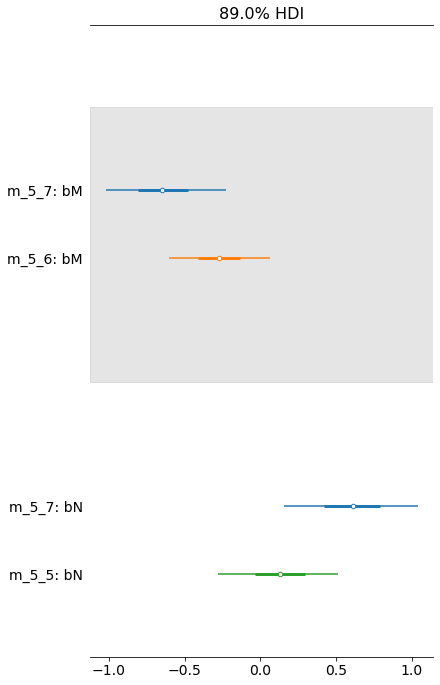

In [23]:
m_5_7_data = az.from_pymc3(m_5_7_trace)
m_5_6_data = az.from_pymc3(m_5_6_trace)
m_5_5_data = az.from_pymc3(m_5_5_trace)


az.plot_forest(
    [m_5_7_data, m_5_6_data, m_5_5_data],
    model_names = ["m_5_7", "m_5_6", "m_5_5"],
    var_names = ["bM", "bN"],
    combined = True, 
    credible_interval = 0.89
)

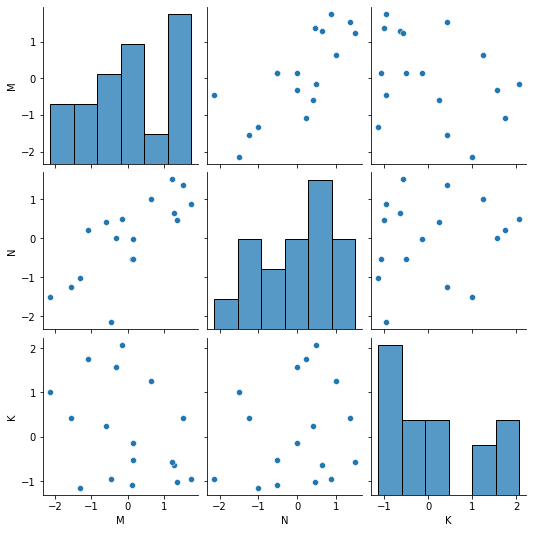

In [24]:
sns.pairplot(milk[["M", "N", "K"]])

Mozne modely, ktere vysvetluji data:

**Model 1**:
M -> K <- N **|**
M -> N


**Model 2**:
M -> K <- N **|**
M -> N


**Model 3**:
M -> K <- N **|**
M <- U* -> N


*unobserved variable


Z dat nedokazeme rici, ktery model je pravdivy. Data vysvetluji vsechny modely. 

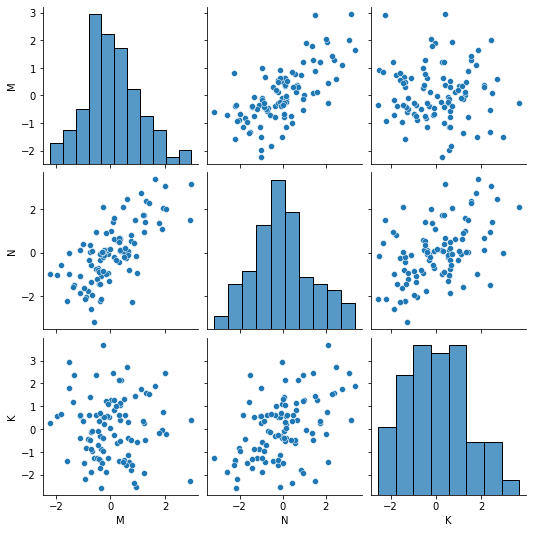

In [25]:
# simulate model 1
# M -> K <- N
# M -> N

n = 100
M = stats.norm.rvs(size = n)
N = stats.norm.rvs(loc = M)
K = stats.norm.rvs(loc = N-M) # protoze M ma negativni vztah, tak odecteme: mu = N - M

df = pd.DataFrame({"M": M, "N": N, "K": K})
sns.pairplot(df)

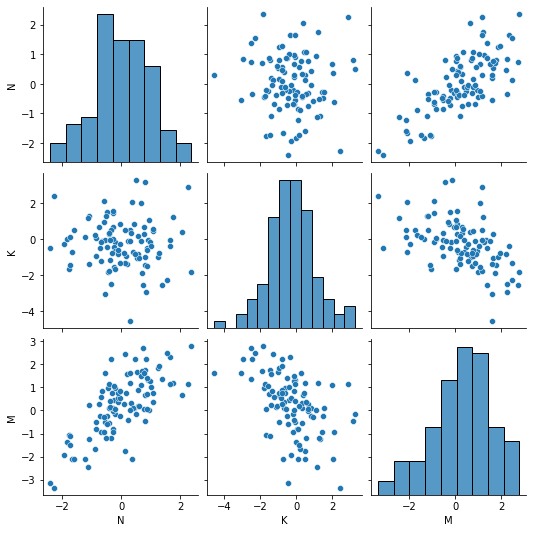

In [26]:
# simulate model 2
# M -> K <- N
# N -> M

n = 100
N = stats.norm.rvs(size = n)
M = stats.norm.rvs(loc = N)
K = stats.norm.rvs(loc = N-M) # protoze M ma negativni vztah, tak odecteme: mu = N - M

df = pd.DataFrame({"N": N, "K": K, "M": M})
sns.pairplot(df)

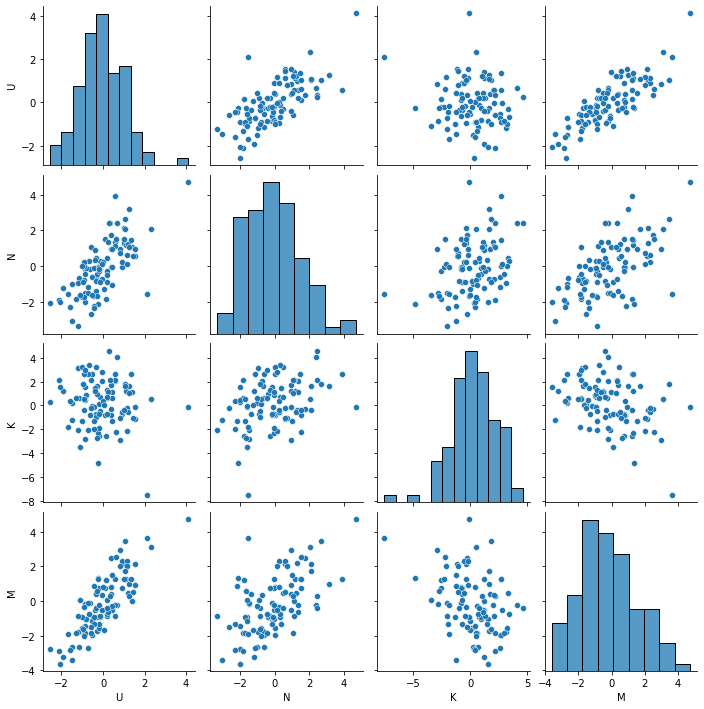

In [27]:
# simulate model 3
# M -> K <- N
# N <- U -> M

n = 100
U = stats.norm.rvs(size = n)
N = stats.norm.rvs(loc = U)
M = stats.norm.rvs(loc = U)
K = stats.norm.rvs(loc = N-M) # protoze M ma negativni vztah, tak odecteme: mu = N - M

df = pd.DataFrame({"U": U, "N": N, "K": K, "M": M})
sns.pairplot(df)

### Categorical variable

Here is a model that predicts number of calories in milk using clade (druh)

$K_i \sim Normal(\mu_i, \sigma)$

$\mu_i = \alpha_{clade[i]}$

$\alpha_j \sim Normal(0, 0.5)$ for j = 1..4

$\sigma \sim Exponential(1)$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

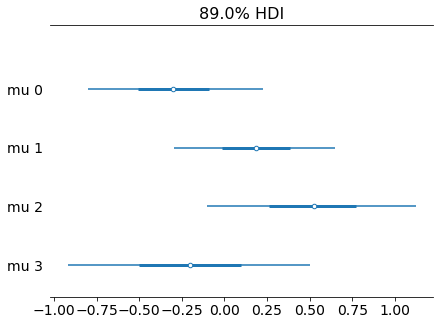

In [75]:
# create a codes categorical variable
milk["clade_id"] = pd.Categorical(milk["clade"]).codes

with pm.Model() as m_5_9:
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Normal("mu", 0, 0.5, shape=milk.clade_id.max() + 1) #plus one because first category is 0
    K = pm.Normal("K", mu[milk.clade_id], sigma, observed=milk["K"]) #for each observation we take mu for cat 0 and mu for cat 1 and ... their sum is mu K
    m_5_9_trace = pm.sample()

az.plot_forest(m_5_9_trace, var_names = ["mu"], combined=True, credible_interval=0.89)

### Exercise

Invent your own example of a spurious correlation. An outcome variable should be correlated
with both predictor variables. But when both predictors are entered in the same model, the correlation
between the outcome and one of the predictors should mostly vanish (or at least be greatly reduced).

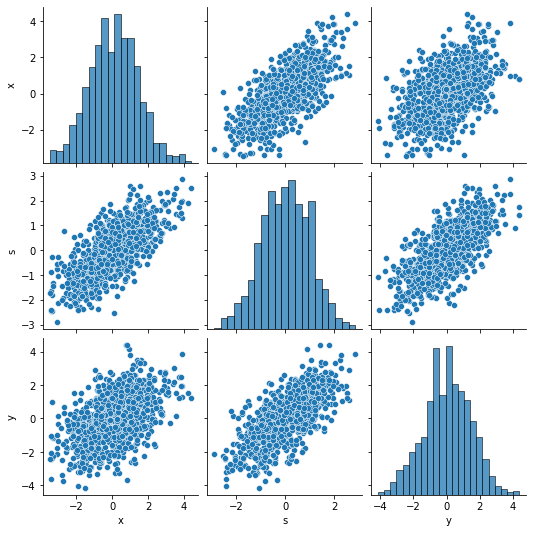

In [55]:
#EM1
# X <- S -> Y
N = 1000
S = stats.norm.rvs(size = N)
X = stats.norm.rvs(loc = S)
Y = stats.norm.rvs(loc = S)

df = pd.DataFrame({"x": X, "s": S, "y": Y})
sns.pairplot(df)

In [56]:
with pm.Model() as em1:
    bX = pm.Normal("bX", 0, 1)
    bS = pm.Normal("bS", 0, 1)
    a  = pm.Normal("a", 0, 1)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bX * X + bS *S)
    y = pm.Normal("y", mu, sigma, observed = Y)
    em1_trace = pm.sample(tune = 1000, draws = 1000)

az.summary(em1_trace, var_names=["bX", "bS"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a, bS, bX]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bX,-0.013,0.033,-0.073,0.049,0.001,0.000,2314.0,2314.0,2316.0,2709.0,1.0
bS,1.026,0.045,0.938,1.106,0.001,0.001,2351.0,2345.0,2347.0,2930.0,1.0


Invent your own example of a masked relationship. An outcome variable should be correlated
with both predictor variables, but in opposite directions. And the two predictor variables should be
correlated with one another.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a, bS, bX]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bX,0.051,0.031,-0.008,0.106,0.001,0.000,2490.0,2331.0,2530.0,2450.0,1.0
bS,1.052,0.045,0.969,1.136,0.001,0.001,2447.0,2435.0,2466.0,2475.0,1.0


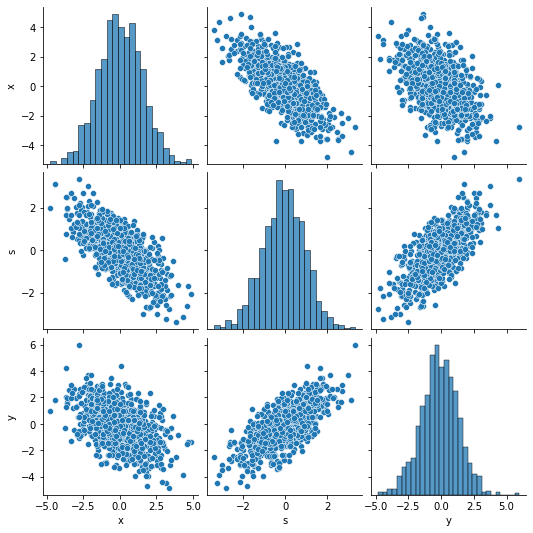

In [57]:
#EM1
# X <- S -> Y
N = 1000
S = stats.norm.rvs(size = N)
X = stats.norm.rvs(loc = -S)
Y = stats.norm.rvs(loc = S)

df = pd.DataFrame({"x": X, "s": S, "y": Y})
sns.pairplot(df)

with pm.Model() as em2:
    bX = pm.Normal("bX", 0, 1)
    bS = pm.Normal("bS", 0, 1)
    a  = pm.Normal("a", 0, 1)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bX * X + bS *S)
    y = pm.Normal("y", mu, sigma, observed = Y)
    em2_trace = pm.sample(tune = 1000, draws = 1000)

az.summary(em2_trace, var_names=["bX", "bS"])